# This is the code for ResNet152V2 using HyperBand Tuner , which was run using GPU accelaration, locally due to computation constraints it couldn't be run under Google Collab.


## Import the libraries
This code Block does the following:

1.   Check for GPU Availability
2.   Detect files and load the files from the folders
3.   Split the dataset intto Train,Validation and Test
4.   The split is 70%, 15%, 15% respectively
5.   Save the split datasets into .csv files for further use
6.   Print the number of samples and percentage for each set.



In [ ]:
#Import Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP, Dense, Dropout
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from keras_tuner import HyperModel, Hyperband
from datetime import datetime
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import time

# GPU configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU instead.")

# Assuming the dataset is unzipped into a folder named "Shoe vs Sandal vs Boot Dataset"
data_dir = "F:\Shoe vs Sandal vs Boot Dataset"

# Save the path in a variable for later use
dataset_path = data_dir

# Change the current working directory to the dataset directory
os.chdir(dataset_path)

# Verify the change of directory
print("Current working directory:", os.getcwd())

# List the subfolders and image files in them
subfolders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]
print("Subfolders:", subfolders)

# Collect all image file paths and their corresponding labels
file_paths = []
labels = []

for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_path, subfolder)
    for file in os.listdir(subfolder_path):
        if file.endswith(('png', 'jpg', 'jpeg')):
            file_paths.append(os.path.join(subfolder_path, file))
            labels.append(subfolder)

# Convert to a DataFrame for easier manipulation
data = pd.DataFrame({'file_path': file_paths, 'label': labels})

# Split the data into train (70%), validation (15%), and test (15%) sets
train_val_data, test_data = train_test_split(data, test_size=0.15, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1765, stratify=train_val_data['label'], random_state=42)  # 0.1765 * 85% ≈ 15%

# Calculate the number of samples in each set
train_count = train_data.shape[0]
val_count = val_data.shape[0]
test_count = test_data.shape[0]
total_count = data.shape[0]

# Create a table for the distribution of samples
distribution_table = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Number of Samples': [train_count, val_count, test_count],
    'Percentage': [train_count/total_count*100, val_count/total_count*100, test_count/total_count*100]
})

print(distribution_table)

# Save the split datasets to CSV files for later use
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)


1 Physical GPUs, 1 Logical GPUs
Current working directory: F:\Shoe vs Sandal vs Boot Dataset
Subfolders: ['Boot', 'Sandal', 'Shoe']
          Set  Number of Samples  Percentage
0       Train              10499   69.993333
1  Validation               2251   15.006667
2        Test               2250   15.000000


##This Code block does the following:



1.   Pre-Processing the Images
2.   Creating the TensorFlow datasets
3.   Building the model- ResnNet152V2
4.   Activation Functions taken :'relu', 'leaky_relu', 'prelu', 'elu', 'swish'
5.   Dense Units Range from 128 - 512 with step = 128
6.   Regulariztion functions are L1,L2,L1_L2, Drop-Out Regularization
7.   Compiles the model with different optimizers and learning rates, functions
8.   It also logs the hyperparameter tuning results to see which trail has best parameters
9.   Evaluate, Print the evaluation results including train, validation, and test accuracy
10.  Evaluation Metrics are Accuracy, Precision, Recall, AUC



In [ ]:
#Pre-Process the Images
def preprocess_image(image_path, label, img_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0
    return image, label

def load_dataset(df, img_size=(256, 256)):
    paths = df['file_path'].values
    labels = pd.get_dummies(df['label']).values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, img_size))
    return dataset

# Create TensorFlow datasets
train_ds = load_dataset(train_data).shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = load_dataset(val_data).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = load_dataset(test_data).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

class ResNetHyperModel(HyperModel):
    def build(self, hp):
        base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
        base_model.trainable = False

        model = Sequential()
        model.add(base_model)
        model.add(GAP())

        # Add first dense layer with activation function and regularization
        activation_fn_1 = hp.Choice('activation_fn_1', values=['relu', 'leaky_relu', 'prelu', 'elu', 'swish'])
        units_1 = hp.Int('dense_units_1', min_value=128, max_value=512, step=128)
        reg_fn_1 = hp.Choice('reg_fn_1', values=['l1', 'l2', 'l1_l2', 'None'])
        reg_rate_1 = hp.Float('reg_rate_1', min_value=1e-5, max_value=1e-2, sampling='LOG')

        if reg_fn_1 == 'l1':
            regularizer_1 = tf.keras.regularizers.l1(reg_rate_1)
        elif reg_fn_1 == 'l2':
            regularizer_1 = tf.keras.regularizers.l2(reg_rate_1)
        elif reg_fn_1 == 'l1_l2':
            regularizer_1 = tf.keras.regularizers.l1_l2(reg_rate_1)
        else:
            regularizer_1 = None

        model.add(Dense(units_1, kernel_regularizer=regularizer_1))

        if activation_fn_1 == 'leaky_relu':
            from tensorflow.keras.layers import LeakyReLU
            model.add(LeakyReLU(alpha=0.1))
        elif activation_fn_1 == 'prelu':
            from tensorflow.keras.layers import PReLU
            model.add(PReLU())
        else:
            model.add(tf.keras.layers.Activation(activation_fn_1))

        model.add(Dropout(hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)))

        # Add second dense layer with activation function and regularization
        activation_fn_2 = hp.Choice('activation_fn_2', values=['relu', 'leaky_relu', 'prelu', 'elu', 'swish'])
        units_2 = hp.Int('dense_units_2', min_value=128, max_value=512, step=128)
        reg_fn_2 = hp.Choice('reg_fn_2', values=['l1', 'l2', 'l1_l2', 'None'])
        reg_rate_2 = hp.Float('reg_rate_2', min_value=1e-5, max_value=1e-2, sampling='LOG')

        if reg_fn_2 == 'l1':
            regularizer_2 = tf.keras.regularizers.l1(reg_rate_2)
        elif reg_fn_2 == 'l2':
            regularizer_2 = tf.keras.regularizers.l2(reg_rate_2)
        elif reg_fn_2 == 'l1_l2':
            regularizer_2 = tf.keras.regularizers.l1_l2(reg_rate_2)
        else:
            regularizer_2 = None

        model.add(Dense(units_2, kernel_regularizer=regularizer_2))

        if activation_fn_2 == 'leaky_relu':
            from tensorflow.keras.layers import LeakyReLU
            model.add(LeakyReLU(alpha=0.1))
        elif activation_fn_2 == 'prelu':
            from tensorflow.keras.layers import PReLU
            model.add(PReLU())
        else:
            model.add(tf.keras.layers.Activation(activation_fn_2))

        model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.2, max_value=0.5, step=0.1)))

        # Add output layer
        model.add(Dense(len(train_data['label'].unique()), activation='softmax'))

        # Compile the model with different optimizers and learning rates
        optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )

        return model

# Callback to log hyperparameter tuning results
class CSVLoggerCallback(Callback):
    def __init__(self, file_name):
        self.file_name = file_name
        self.columns_written = False
        self.trial_id = None

    def on_epoch_end(self, epoch, logs=None):
        if not self.columns_written:
            with open(self.file_name, 'w') as f:
                f.write(','.join(['trial_id', 'epoch'] + list(logs.keys())) + '\n')
            self.columns_written = True
        with open(self.file_name, 'a') as f:
            f.write(','.join([str(self.trial_id), str(epoch)] + [str(logs[k]) for k in logs.keys()]) + '\n')

    def on_trial_begin(self, trial):
        self.trial_id = trial.trial_id  # Set the trial_id here

    def on_trial_end(self, trial):
        trial_result = trial.hyperparameters.values.copy()
        trial_result['trial_id'] = trial.trial_id
        trial_result['score'] = trial.score
        with open(self.file_name, 'a') as f:
            f.write(','.join([str(trial_result[k]) for k in trial_result.keys()]) + '\n')

# Initialize the tuner
tuner = Hyperband(
    ResNetHyperModel(),
    objective='val_accuracy',
    max_epochs=12,
    factor=3,
    directory='hyperband_dir',
    project_name='shoe_sandal_boot'
)

# Define callbacks including TensorBoard and CSVLoggerCallback
log_dir = os.path.join("logs", "ResNet_" + datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0),
    CSVLoggerCallback(file_name='hyperparameter_search_results.csv')
]

# Search for the best hyperparameters
print("\nSearching for the best hyperparameters...")
tuner.search(train_ds, validation_data=valid_ds, epochs=20, callbacks=callbacks)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hps.values)

# Evaluate Model
print("\nEvaluating using best model...")
start_time = time.time()
train_results = best_model.evaluate(train_ds)
train_eval_time = time.time() - start_time

start_time = time.time()
val_results = best_model.evaluate(valid_ds)
val_eval_time = time.time() - start_time

start_time = time.time()
test_results = best_model.evaluate(test_ds)
test_eval_time = time.time() - start_time

# Print the evaluation results including train, validation, and test accuracy
evaluation_results = {
    'set': ['train', 'validation', 'test'],
    'accuracy': [train_results[1], val_results[1], test_results[1]],
    'precision': [train_results[2], val_results[2], test_results[2]],
    'recall': [train_results[3], val_results[3], test_results[3]],
    'auc': [train_results[4], val_results[4], test_results[4]],
    'evaluation_time': [train_eval_time, val_eval_time, test_eval_time]
}

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df.to_csv('evaluation_results.csv', index=False)

print("Evaluation results (best model):")
print(evaluation_df)

# Clear session to release GPU memory
tf.keras.backend.clear_session()


Trial 30 Complete [00h 23m 38s]
val_accuracy: 0.9751221537590027

Best val_accuracy So Far: 0.9822301268577576
Total elapsed time: 07h 03m 21s
Best hyperparameters:
{'activation_fn_1': 'leaky_relu', 'dense_units_1': 256, 'reg_fn_1': 'l2', 'reg_rate_1': 4.495751680602005e-05, 'dropout_rate_1': 0.2, 'activation_fn_2': 'relu', 'dense_units_2': 384, 'reg_fn_2': 'l2', 'reg_rate_2': 0.0026095213619897165, 'dropout_rate_2': 0.30000000000000004, 'optimizer': 'adam', 'learning_rate': 0.00012982342634960264, 'tuner/epochs': 12, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}

Evaluating using best model...
71/71 [==============================] - 34s 480ms/step - loss: 0.1317 - accuracy: 0.9822 - precision: 0.9822 - recall: 0.9818 - auc: 0.9965
Evaluation results (best model):
          set  accuracy  precision    recall       auc  evaluation_time
0       train  0.999143   0.999238  0.999143  0.999999       159.848959
1  validation  0.982230   0.982659  

### Using The above code has performed 30 Trials have been performed to find the best possible Hyper-Parameters using the hyperband Tuner.

Total Training Time was **7 Hours and 3 Minutes and 21 Seconds**

The best parameters are these:
1.   Activation Function 1 & 2 : Leaky Relu, Relu
2.   Dense units 1,2 : 256 , 384
3.   Regularization Function 1 &2 : L2
4.   Regularization Rate 1 & 2 : 4.49e-05, 0.002609
5.   Dropout Rate 1 & 2 : 0.2, 0.3
6.   Optimizer : Adam
7.   Learning Rate : 0.000129



### This code is used for getting data from the .json data frames of HyperTuner directory to print and compare results and values of each trial along with the corresponding metrics and save into .csv file


In [ ]:
import json
import pandas as pd
import os
import glob

# Function to load a JSON file
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Path to the directory containing the JSON files
base_dir = 'F:\\Shoe vs Sandal vs Boot Dataset\\hyperband_dir'

# Find all JSON files in the directory and its subdirectories
json_files = glob.glob(os.path.join(base_dir, '**', '*.json'), recursive=True)

# List to store the records
records = []

# Process each JSON file
for json_file in json_files:
    data = load_json(json_file)

    # Ensure the JSON file contains trial data
    if 'trial_id' in data:
        trial_id = data['trial_id']
        hyperparameters = data['hyperparameters']['values']
        metrics = data['metrics']['metrics']

        # Flatten the metrics dictionary to get only the final values
        final_metrics = {k: v['observations'][0]['value'][0] for k, v in metrics.items()}

        # Filter out hyperparameters that are default values
        space = {param['config']['name']: param['config']['default'] for param in data['hyperparameters']['space']}
        hyperparameters = {k: v for k, v in hyperparameters.items() if space.get(k) != v}

        record = {'trial_id': trial_id}
        record.update(hyperparameters)
        record.update(final_metrics)

        records.append(record)

# Convert to DataFrame
df = pd.DataFrame(records)

# Save to CSV
csv_file_path = 'hyper_tuner_results.csv'
df.to_csv(csv_file_path, index=False)

print(f"Hyperparameters and metrics have been saved to {csv_file_path}")


Hyperparameters and metrics have been saved to hyper_tuner_results.csv


### This code utilizes the .csv files and makes a dataframe and explores the performance of each trial and compares them using a Bar Chart

First few rows of the DataFrame:
   trial_id activation_fn_1  dense_units_1 reg_fn_1  reg_rate_1  \
0         0             elu            384     None    0.000040   
1         1             elu            384      NaN    0.000163   
2         2      leaky_relu            256       l2    0.000045   
3         3           prelu            384       l2    0.000069   
4         4           prelu            256     None    0.000430   

   dropout_rate_1 activation_fn_2  dense_units_2 reg_fn_2  reg_rate_2  ...  \
0             0.3      leaky_relu            256       l2    0.000641  ...   
1             0.4      leaky_relu            384       l2    0.000058  ...   
2             NaN             NaN            384       l2    0.002610  ...   
3             0.4             NaN            256       l2    0.000017  ...   
4             NaN      leaky_relu            256     None    0.006611  ...   

   accuracy precision    recall       auc  val_loss  val_accuracy  \
0  0.823126  0.862586  0.7

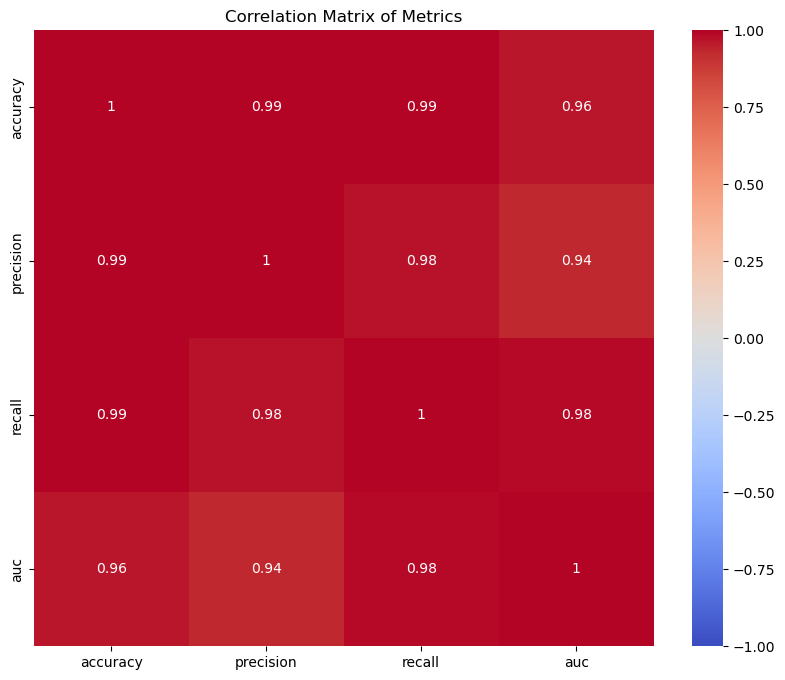


Trial ID with the best accuracy: 17


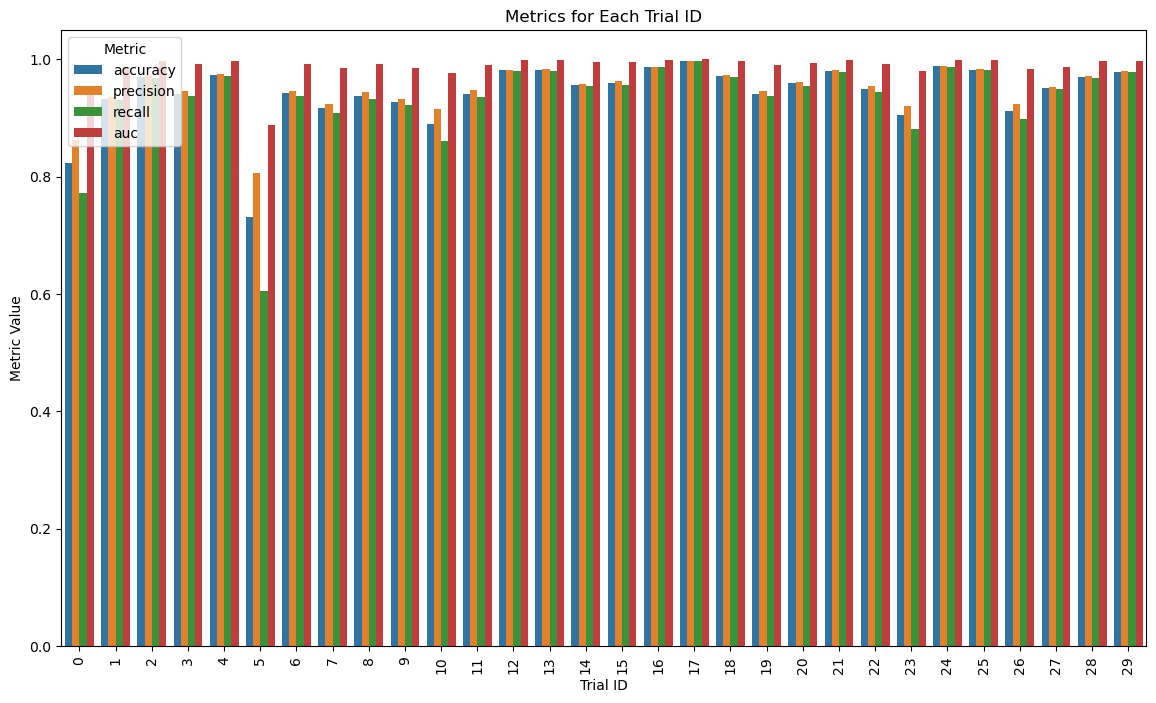

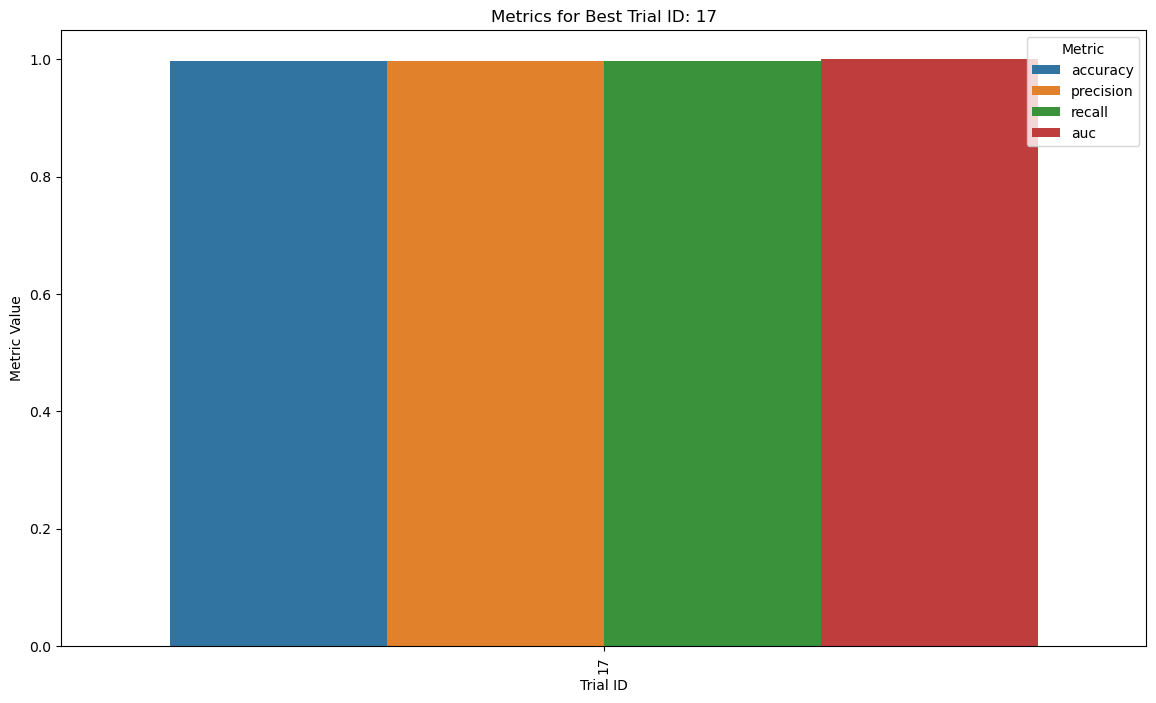

,trial_id,dense_units_1,reg_rate_1,dropout_rate_1,dense_units_2,reg_rate_2,dropout_rate_2,learning_rate,tuner/epochs,tuner/initial_epoch,...,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc,tuner/trial_id
count,30.000000,30.000000,30.000000,16.000000,30.000000,30.000000,23.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,8.000000
mean,14.500000,315.733333,0.000619,0.325000,315.733333,0.001482,0.326087,0.002315,5.333333,0.800000,...,0.942471,0.950448,0.931927,0.987573,3.127426,0.958759,0.963970,0.950807,0.993342,9.875000
std,8.803408,129.025775,0.001076,0.044721,133.332598,0.002284,0.044898,0.002643,4.179864,1.447947,...,0.053529,0.039354,0.076837,0.021601,8.751796,0.025586,0.016545,0.044805,0.005787,7.395703
min,0.000000,128.000000,0.000016,0.300000,128.000000,0.000014,0.300000,0.000130,2.000000,0.000000,...,0.731403,0.806398,0.605010,0.888035,0.081254,0.868947,0.925081,0.756997,0.969453,1.000000
25%,7.250000,256.000000,0.000055,0.300000,256.000000,0.000050,0.300000,0.000310,2.000000,0.000000,...,0.933827,0.938272,0.930708,0.986774,0.184988,0.953576,0.957358,0.950022,0.992831,3.500000
50%,14.500000,320.000000,0.000142,0.300000,256.000000,0.000398,0.300000,0.001855,4.000000,0.000000,...,0.953615,0.956302,0.951757,0.993422,0.455279,0.965793,0.968080,0.963350,0.995621,10.000000
75%,21.750000,384.000000,0.000500,0.325000,384.000000,0.002314,0.350000,0.002415,10.000000,1.500000,...,0.976903,0.978047,0.976045,0.997437,0.993174,0.975122,0.976196,0.974678,0.996240,14.250000
max,29.000000,512.000000,0.004488,0.400000,512.000000,0.007288,0.400000,0.008890,12.000000,4.000000,...,0.996666,0.996666,0.996571,0.999897,36.241524,0.982230,0.982659,0.981786,0.997106,21.000000


In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
csv_file_path = r'F:\Shoe vs Sandal vs Boot Dataset\hyper_tuner_results.csv'
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())
print(df.tail())



# Perform correlation analysis on the metrics
metrics = ['accuracy', 'precision', 'recall', 'auc']
correlation_matrix = df[metrics].corr()

print("\nCorrelation matrix:")
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Metrics')
plt.show()

# Identify the trial ID with the best metrics
# Here, we'll consider the trial with the highest accuracy as the best
best_trial_id = df.loc[df['accuracy'].idxmax(), 'trial_id']

print(f"\nTrial ID with the best accuracy: {best_trial_id}")

# Plot bar charts of metrics for each trial
df_melted = df.melt(id_vars=['trial_id'], value_vars=metrics, var_name='metric', value_name='value')

plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted, x='trial_id', y='value', hue='metric')
plt.title('Metrics for Each Trial ID')
plt.xlabel('Trial ID')
plt.ylabel('Metric Value')
plt.xticks(rotation=90)
plt.legend(title='Metric')
plt.show()

# Highlight the best trial in the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted[df_melted['trial_id'] == best_trial_id], x='trial_id', y='value', hue='metric')
plt.title(f'Metrics for Best Trial ID: {best_trial_id}')
plt.xlabel('Trial ID')
plt.ylabel('Metric Value')
plt.xticks(rotation=90)
plt.legend(title='Metric')
plt.show()

df.describe()